In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rrcf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Read csv file
df_pH = pd.read_csv("Data_Raw_Water.csv")
print('The number of samples of the data ', len(df_pH))
df_pH.head()

The number of samples of the data  2658


,time,turbidity,pH
0,2020-11-04 11:00:31.822439+00:00,21.063435,7.34
1,2020-11-04 11:01:22.124333+00:00,20.868153,7.33
2,2020-11-04 11:01:51.663062+00:00,20.584553,7.32
3,2020-11-04 11:02:29.373718+00:00,21.185328,7.33
4,2020-11-04 11:03:45.517010+00:00,21.063435,7.32


In [3]:
# Convert dataframe to array
pH_train= np.array(df_pH['pH'])

In [4]:
# Set tree parameters
num_trees = 30
shingle_size = 1
tree_size = 200


In [5]:
# Create a forest of empty trees
forest = []
for _ in range(num_trees):
    tree = rrcf.RCTree()
    forest.append(tree)


In [6]:
# Use the "shingle" generator to create rolling window
points = rrcf.shingle(pH_train, size=shingle_size)

# Create a dict to store anomaly score of each point
avg_codisp = {}

In [7]:
%%time
# Display prediction result

for index, point in enumerate(points):
    # For each tree in the forest...
    for tree in forest:
        # If tree is above permitted size, drop the oldest point
        # (FIFO)
        if len(tree.leaves) > tree_size:
            tree.forget_point(index - tree_size)
        # Insert the new point into the tree
        tree.insert_point(point, index=index)
        # Compute codisp on the new point and take the average among
        # all trees
        if not index in avg_codisp:
            avg_codisp[index] = 0
        avg_codisp[index] += tree.codisp(index) / num_trees

Wall time: 3min 20s


In [8]:
# Convert score dictionary to data frame.
pH_result = pd.DataFrame.from_dict(avg_codisp,'index')

In [9]:
# Merge score with data.
df_pH['Score'] = pH_result

In [10]:
#Try different values of threshold to get anomalies.
anomalies = df_pH.loc[df_pH['Score']>30]
anomalies_only = anomalies[['time', 'pH', 'Score']]
anomalies_only

,time,pH,Score
137,2020-11-07 07:21:50.023060+00:00,7.36,34.171028
141,2020-11-07 09:22:54.202949+00:00,7.36,34.350225
165,2020-11-07 23:30:23.619649+00:00,7.36,41.665103
168,2020-11-08 01:01:11.778912+00:00,7.36,42.197389
171,2020-11-08 02:31:59.938643+00:00,7.36,42.743329
...,...,...,...
2645,2021-01-04 03:51:12.500086+00:00,7.36,47.471839
2646,2021-01-04 04:21:28.547078+00:00,7.36,47.077020
2647,2021-01-04 04:51:44.627202+00:00,7.36,47.026268
2656,2021-01-04 09:24:09.578901+00:00,7.36,46.379873


In [11]:
len(anomalies)

481

Text(0.5, 1.0, 'Water pH data (Red) and Anomaly Score (Blue)\n')

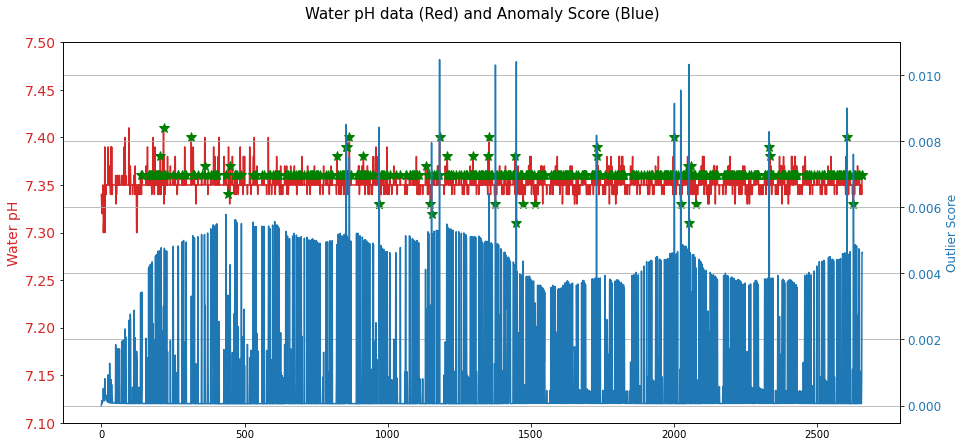

In [13]:
for index in range(len(avg_codisp)):
    avg_codisp[index]=avg_codisp[index]/100
    
fig, ax1 = plt.subplots(figsize=(15, 7))
color = 'tab:red'
ax1.set_ylabel('Water pH', color=color, size=14)
ax1.plot(pH_train, color=color)
plt.plot(anomalies['pH'], "g*", markersize =10)
ax1.tick_params(axis='y', labelcolor=color, labelsize=14)
ax1.set_ylim(7.1,7.5)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Outlier Score', color=color, size=12)
ax2.plot(pd.Series(avg_codisp).sort_index(), color=color)
ax2.tick_params(axis='y', labelcolor=color, labelsize=12)
ax2.grid('off')
#ax2.set_ylim(0,100)
plt.title('Water pH data (Red) and Anomaly Score (Blue)\n', size=15)